## Description
This notebook creates the mobility matrices (frequent travelers and incidental travelers) that are used in the COVID-19 model. The mobility matrices follow the gravity model for mobility, where the likeliness of traveling from municipality A to B is directly proportional to the municipalities' population and inversely proportional to the distance between the municipalities.

In [2]:
import pandas as pd
import numpy as np
from geopy import distance
import math
import matplotlib.pyplot as plt

In [3]:
raw_municipality_data = pd.read_csv("Gemeenten2018.csv");
municipality_list = raw_municipality_data[["Gemeentenaam", "Gemeentecode"]]

In [4]:
municipality_list.size

760

In [5]:
population = pd.read_csv("Regionale_kerncijfers_Nederland_22072022_132648.csv", sep=';')[["Regio's", "aantal"]]

In [6]:
population.dropna(inplace=True)

In [7]:
population.aantal = population.aantal.astype(int)

In [8]:
# Replace municipality names with the ones from Gemeenten2018.csv (the vary slightly)
population["Regio's"] = municipality_list.Gemeentenaam.values

In [9]:
population.to_csv("inwoners_gemeente_2018.csv",index=False)

In [10]:
population

,Regio's,aantal
0,Aa en Hunze,25390
1,Aalburg,13153
2,Aalsmeer,31499
3,Aalten,26962
7,Achtkarspelen,27935
...,...,...
719,Zundert,21525
720,Zutphen,47537
721,Zwartewaterland,22468
724,Zwijndrecht,44586


In [11]:
municipalities_coordinates = pd.read_csv("municipalities_coordinates_2018.csv");

In [12]:
# Check if the municipality names match
municipalities_coordinates.Municipality.reset_index(drop=True).equals(population["Regio's"].reset_index(drop=True))

True

In [13]:
# Create distance matrix using the coordinates
length = len(municipalities_coordinates)
distance_matrix = np.zeros((length, length))
for index_a, row_a in municipalities_coordinates.iterrows():
    for index_b, row_b in municipalities_coordinates.iterrows():
        coord_a = (row_a['Lat'], row_a['Lng'])
        coord_b = (row_b['Lat'], row_b['Lng'])
        dist = distance.distance(coord_a, coord_b).km
        distance_matrix[index_a, index_b] = dist

In [14]:
# Create M_freq and M_inc
# For M_freq(i,j) = 0.5 * (P(i) * P(j))/ D(i,j)
M_freq = np.zeros((length, length))
M_inc = np.zeros((length, length))
for index_a, row_a in municipalities_coordinates.iterrows():
    for index_b, row_b in municipalities_coordinates.iterrows():
        # Going from location A to location A
        if (math.isclose(distance_matrix[index_a, index_b], 0, rel_tol=1e-5)):
            dist = 1
        else:
            dist = distance_matrix[index_a, index_b]
        M_freq[index_a, index_b] = 0.5*(population.iloc[index_a]['aantal'] * population.iloc[index_b]['aantal'])/(dist**1)
        M_inc[index_a, index_b] = (1/7)*(population.iloc[index_a]['aantal'] * population.iloc[index_b]['aantal'])/(dist**0.5)

In [15]:
# Verify that matrices are symmetrical
np.allclose(M_freq, M_freq.T, rtol=1e-8, atol=1e-8)

True

In [16]:
np.allclose(M_inc, M_inc.T, rtol=1e-8, atol=1e-8)

True

(array([14., 26., 43., 47., 49., 35., 52., 31., 34., 22., 11., 12.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  1.]),
 array([ 61366.99924736,  78806.54955344,  96246.09985952, 113685.65016561,
        131125.20047169, 148564.75077777, 166004.30108386, 183443.85138994,
        200883.40169602, 218322.95200211, 235762.50230819, 253202.05261427,
        270641.60292035, 288081.15322644, 305520.70353252, 322960.2538386 ,
        340399.80414469, 357839.35445077, 375278.90475685, 392718.45506294,
        410158.00536902, 427597.5556751 , 445037.10598119, 462476.65628727,
        479916.20659335, 497355.75689944, 514795.30720552, 532234.8575116 ,
        549674.40781769, 567113.95812377, 584553.50842985]),
 <BarContainer object of 30 artists>)

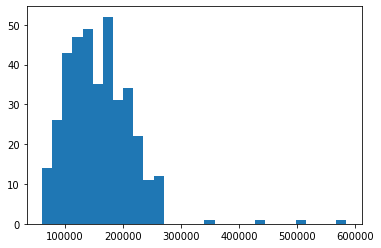

In [17]:
rowsum_freq = np.sum(M_freq, axis=0) / np.array(population['aantal'])
plt.hist(rowsum_freq, bins=30)

(array([ 9.,  8.,  9., 19., 18., 14., 17., 14., 12., 15., 19., 22., 21.,
        17., 17., 24., 19., 26., 19., 23., 27.,  7.,  0.,  0.,  2.,  0.,
         0.,  1.,  0.,  1.]),
 array([198908.44433073, 206465.30990364, 214022.17547655, 221579.04104946,
        229135.90662237, 236692.77219528, 244249.63776819, 251806.5033411 ,
        259363.36891401, 266920.23448692, 274477.10005983, 282033.96563274,
        289590.83120565, 297147.69677856, 304704.56235147, 312261.42792438,
        319818.29349729, 327375.1590702 , 334932.02464311, 342488.89021601,
        350045.75578892, 357602.62136183, 365159.48693474, 372716.35250765,
        380273.21808056, 387830.08365347, 395386.94922638, 402943.81479929,
        410500.6803722 , 418057.54594511, 425614.41151802]),
 <BarContainer object of 30 artists>)

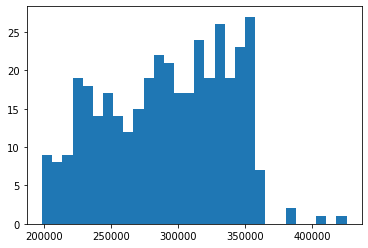

In [18]:
rowsum_inc = np.sum(M_inc, axis=0) / np.array(population['aantal'])
plt.hist(rowsum_inc, bins=30)

333


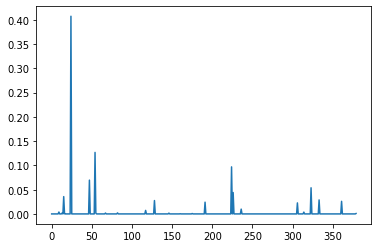

In [170]:
# Amstelveen 14, Voorst 333
# r = 333
# lst = np.copy(M_freq[r])
# lst = lst / population.iloc[r]["aantal"]
# # lst[r] = 1
# lst = 2.5*lst / np.sum(lst)
# locations = np.zeros(380)
# for i in range(0, 1000):
#     fs = np.array(np.random.dirichlet(lst))
#     max_index = max(range(len(fs)), key=fs.__getitem__)
#     locations[max_index] = locations[max_index] + 1

import matplotlib.pyplot as plt
# print(max(range(len(fs)), key=fs.__getitem__))
plt.plot(fs)
plt.savefig('/tmp/voorst_dirichlet_draw.svg', format='svg')
# plt.plot(locations)
print(max(range(len(locations)), key=locations.__getitem__))

In [167]:
hs = np.round(fs*24, 0)
# hs = hs / np.sum(hs) * 24
hs = hs.astype(int)

In [168]:
hs

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [21]:
# M_inc_norm = normalize(M_inc, axis=0, norm='l1')

In [22]:
# np.savetxt("M_inc.csv", M_inc, delimiter=",")
# np.savetxt("M_freq.csv", M_freq, delimiter=",")